# Model 6
Train deep learning algorithm and predict SCF to use in `HMASR_100km_calibration.ipynb`

Env: `tf2_v0`

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf # Machine learning

## Load data

In [2]:
path = '/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_100km/'

# Snow depth
ds = xr.open_mfdataset(path+'HMA_SR_D_v01_100km_WY*_SD_POST.nc')
sd = ds.SD_Post.load()

# SCF
ds = xr.open_mfdataset(path+'HMA_SR_D_v01_100km_WY*_SWE_SCA_POST.nc')
swe = ds.SWE_Post.load()
scf= ds.SCA_Post.load()


# Mask
mask = xr.open_dataarray('Non_seasonal_snow_mask_100km.nc').load()

# Topo
# A remplacer par le fichier original en masquant les zones de neige permanente ?
latlim = slice(mask.lat.min().values.item(0)-0.5, mask.lat.max().values.item(0)+0.5)
lonlim = slice(mask.lon.min().values.item(0)-0.5, mask.lon.max().values.item(0)+0.5)

ds = xr.open_dataset('../data/HMASR_DEM_100km.nc')
topo = ds.elevation_seassnow.load()
topo_std = ds.std_seassnow.load()

## Make plot functions

### Compute weights
Taking into account:
- cos(lat)
- fraction of seasonal snow in a grid cell
- exclude cells with >30% of permanent snow

Weigths used to compute metrics (but not for optimization? -> maybe)

In [3]:
lat_weights = np.cos(np.deg2rad(scf.lat))
frac_seasonal_snow = (1-mask/100).where(scf[0]*0+1 == 1)
temp = (frac_seasonal_snow*lat_weights).where(mask<30)
weights = (temp / temp.sum()).fillna(0)
np.testing.assert_equal(weights.sum().values.item(0), 1)

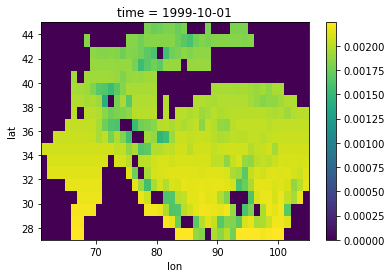

In [4]:
weights.plot()

In [4]:
train_period = slice('1999-10-01', '2013-09-30') # ~80%
val_period = slice('2013-10-01', '2017-09-30') # ~20%

## Machine learning

In [15]:
y_true = [[0., 1.], [0., 0.]]
y_pred = [[1., 1.], [1., 0.]]
# Using 'auto'/'sum_over_batch_size' reduction type.
mse = tf.keras.losses.MeanSquaredError()
mse(y_true, y_pred).numpy()
mse(y_true, y_pred, sample_weight=[0.7, 0.3]).numpy()

0.25

In [5]:
weights_ext = scf.copy()
for i in range(weights_ext.time.size):
    weights_ext[i] = weights
weights_ext = weights_ext.where(scf*0 == 0)

ds = scf.to_dataset(name='SCF')
ds['SD'] = sd
ds['SWE'] = swe
ds['STD'] = topo_std
ds['weights'] = weights_ext
ds

<xarray.Dataset>
Dimensions:  (lat: 18, lon: 44, time: 6575)
Coordinates:
  * lat      (lat) float64 27.5 28.5 29.5 30.5 31.5 ... 40.5 41.5 42.5 43.5 44.5
  * lon      (lon) float64 61.5 62.5 63.5 64.5 65.5 ... 101.5 102.5 103.5 104.5
  * time     (time) datetime64[ns] 1999-10-01 1999-10-02 ... 2017-09-30
Data variables:
    SCF      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    SD       (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    SWE      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    STD      (lat, lon) float32 nan nan nan nan nan ... nan nan nan nan nan
    weights  (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

In [6]:
df_train = ds.sel(time=train_period).to_dataframe()
df_test = ds.sel(time=val_period).to_dataframe()

In [7]:
df_train = df_train.dropna()
df_test = df_test.dropna()

df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

train_dataset = df_train[['SCF', 'SWE', 'SD', 'STD']]
test_dataset = df_test[['SCF', 'SWE', 'SD', 'STD']]

train_weights = df_train[['weights']]
test_weights = df_test[['weights']]

x_train = train_dataset.copy()
x_test = test_dataset.copy()

y_train = x_train.pop('SCF')
y_test = x_test.pop('SCF')

x_train_norm = (x_train - x_train.mean()) / x_train.std()
x_test_norm = (x_test - x_train.mean()) / x_train.std()

x_train_arr, y_train_arr = np.array(x_train_norm), np.array(y_train)
x_test_arr,  y_test_arr  = np.array(x_test_norm),  np.array(y_test)

In [8]:
def get_model_v1(shape):
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape, name="InputLayer"))
    model.add(tf.keras.layers.Dense(8, activation='relu', name='Dense_n1'))
    model.add(tf.keras.layers.Dense(16, activation='relu', name='Dense_n2'))
    model.add(tf.keras.layers.Dense(32, activation='relu', name='Dense_n3'))
    model.add(tf.keras.layers.Dense(16, activation='relu', name='Dense_n4'))
    model.add(tf.keras.layers.Dense(8, activation='relu', name='Dense_n5'))
    
    # Output
    # The sigmoid actiavation allow to keep results between 0 and 1
    model.add(tf.keras.layers.Dense(1, activation='sigmoid', name='Output'))
    
    model.compile(optimizer = 'adam',
                  loss      = 'mse' )
    
    return model

In [9]:
input_size = len(x_train_arr[0])
model = get_model_v1( (input_size,) )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_n1 (Dense)            (None, 8)                 32        
                                                                 
 Dense_n2 (Dense)            (None, 16)                144       
                                                                 
 Dense_n3 (Dense)            (None, 32)                544       
                                                                 
 Dense_n4 (Dense)            (None, 16)                528       
                                                                 
 Dense_n5 (Dense)            (None, 8)                 136       
                                                                 
 Output (Dense)              (None, 1)                 9         
                                                                 
Total params: 1,393
Trainable params: 1,393
Non-trainabl

2022-02-15 10:13:00.933384: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
history = model.fit(x_train_arr,
                    y_train_arr,
                    epochs          = 100,
                    batch_size      = 10,
                    verbose         = 1,
                    sample_weight=train_weights,
                    validation_data = (x_test_arr, y_test_arr, test_weights))

Epoch 1/100
267463/267463 [==============================] - 426s 2ms/step - loss: 1.0219e-05 - val_loss: 1.0039e-05
Epoch 2/100
267463/267463 [==============================] - 324s 1ms/step - loss: 9.8149e-06 - val_loss: 1.0048e-05
Epoch 3/100
267463/267463 [==============================] - 298s 1ms/step - loss: 9.7506e-06 - val_loss: 9.8897e-06
Epoch 4/100
267463/267463 [==============================] - 317s 1ms/step - loss: 9.7173e-06 - val_loss: 9.9347e-06
Epoch 5/100
267463/267463 [==============================] - 328s 1ms/step - loss: 9.6939e-06 - val_loss: 9.8930e-06
Epoch 6/100
267463/267463 [==============================] - 345s 1ms/step - loss: 9.6720e-06 - val_loss: 9.8939e-06
Epoch 7/100
267463/267463 [==============================] - 308s 1ms/step - loss: 9.6557e-06 - val_loss: 9.8907e-06
Epoch 8/100
267463/267463 [==============================] - 360s 1ms/step - loss: 9.6430e-06 - val_loss: 9.9085e-06
Epoch 9/100
267463/267463 [==============================] - 328

KeyboardInterrupt: 

In [13]:
score = model.evaluate(x_test_arr, y_test_arr, verbose=1, sample_weight=test_weights)

print('x_test / loss      : {:5.4f}'.format(score[0]))
# print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[1]))

23879/23879 [==============================] - 14s 573us/step - loss: 9.6582e-06


TypeError: 'float' object is not subscriptable

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

NameError: name 'history' is not defined

In [ ]:
df = pd.DataFrame(data=history.history)
# print("min( val_mae ) : {:.4f}".format( min(history.history["val_mean_absolute_error"]) ) )
df.plot()

In [ ]:
df = ds.to_dataframe()
df = df.dropna()
df.reset_index(inplace=True)
df_subset = df[['SCF', 'SWE', 'SD', 'STD']]
df_subset.pop('SCF')
df_val_norm = (df_subset - x_train.mean()) / x_train.std()
x_val_arr = np.array(df_val_norm)
y_out = model.predict(x_val_arr)

In [ ]:
temp = ds.to_dataframe()
df_param = temp.dropna()
df_param['SCF'] = y_out
scf_param = xr.Dataset.from_dataframe(df_param).SCF.transpose("time", "lat", "lon")

In [ ]:
scf_param.to_netcdf('results/scf_100km_ML5.nc')